In [3]:
# Libraries needed 
import filterpy
from filterpy.common import Q_discrete_white_noise
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist
from filterpy.kalman import KalmanFilter
##

In [4]:
# upload data 
hdf5data_109 = h5py.File('../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../Data/data_143.h5', 'r')

## Transferring data into a dataframe 

In [5]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [6]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [7]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [8]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    df_complete['elapsed_time'] = df_complete['timestamp'] - df_complete['timestamp'].min()
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109,0.000000
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109,0.000000
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109,0.000000
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109,0.000000
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130,0.047641
...,...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109,59.920729
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142,59.927601
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142,59.927601
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143,59.967542


In [9]:
# define coordinate transformation useful to find credibility levels
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )

In [53]:
def credibility_level(df):
    df['credibility_level'] = np.zeros(shape = len(df.index))
    for ind,row in df.iterrows():
        coordinates = row[['X_box','Y_box','Z_box']]
        
        if row['camera'] == 109: 
            df.at[ind,'credibility_level'] = level_affidability_109(coordinates);
            
                    
        elif row['camera'] == 130:
            df.at[ind,'credibility_level'] = level_affidability_130(coordinates);
            
            
        elif row['camera'] == 142:
            df.at[ind,'credibility_level'] = level_affidability_142(coordinates);
         
        
        if row['camera'] == 143:
            df.at[ind,'credibility_level'] = level_affidability_143(coordinates);
        

                
def level_affidability_109(coordinates):
    world2cam = hdf5data_109['TMatrixWorldToCam']
    cam2im = hdf5data_109['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    sloap1 = (-250 + 121.374145)/(600-296.40511363)
    sloap2 = 8/65
    if - img_coord[1] <= sloap1*(img_coord[0] - 600) - 250:
        return 1
    elif - img_coord[1] <= sloap2*(img_coord[0]) - 180:
        return 0.75
    else:
        return 0.25

    
def level_affidability_130(coordinates):
    world2cam = hdf5data_130['TMatrixWorldToCam']
    cam2im = hdf5data_130['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] <= 630) & (img_coord[1] >= 100):
        return 1
    elif (img_coord[0] <= 560) & (img_coord[0] >= 420):
        return 0.25
    else: 
        return 0.5
    

    
def level_affidability_142(coordinates):
    world2cam = hdf5data_142['TMatrixWorldToCam']
    cam2im = hdf5data_142['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] <= 600) & (img_coord[0] >= 380) & (img_coord[1] <= 120):
        return 0.25
    elif img_coord[1] > 120:
        return 1
    else: 
        return 0.75

    
def level_affidability_143(coordinates):
    world2cam = hdf5data_143['TMatrixWorldToCam']
    cam2im = hdf5data_143['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] >= 410) & (img_coord[1] <= 120):
        return 0.25
    if (img_coord[0] < 410) & (img_coord[1] <= 120):
        return 0.5
    else: 
        return 1

In [11]:
credibility_level(df_complete)

## Frame visualization

In [73]:
def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    plt.plot((0,800),(120,120), color = 'red', linewidth = 3)
    plt.plot((410,410),(0,120), color = 'yellow', linewidth = 3)
    
    
    
    
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return


def visualize_alldetections(df, frame_idx = None):
    ''' Visualize all detections from above'''
    if frame_idx is not None:
        x = df['X_box'][df['frame'] == frame_idx]
        y = df['Y_box'][df['frame'] == frame_idx]
        display(df[df['frame'] == frame_idx])
    
    else:
        x = df['X_box']
        y = df['Y_box']
        
    plt.scatter(x,y)
    

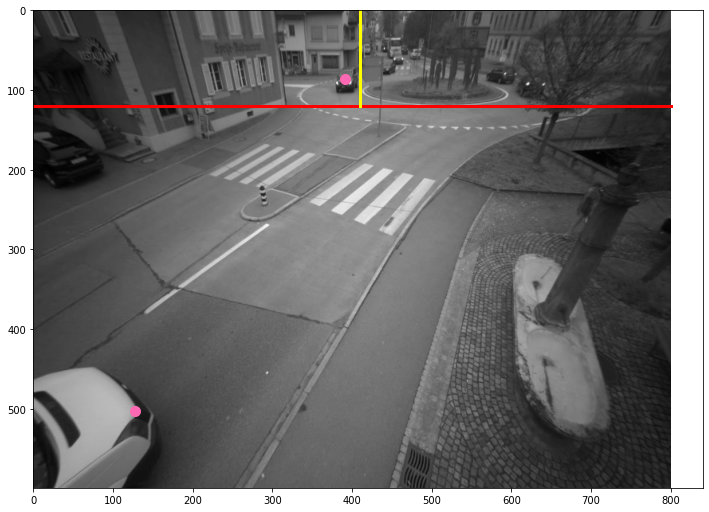

In [75]:
visualize_frame_detections(hdf5data_143,380, figsize = (12,12))

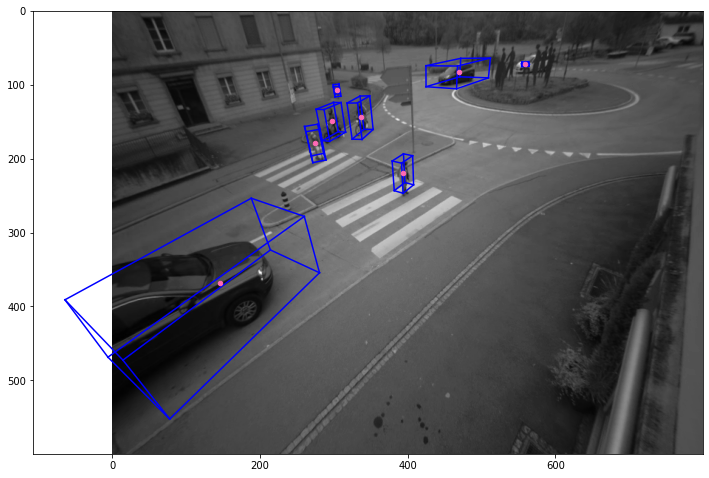

In [37]:
visualize_frame_boxes(hdf5data_109, 260, figsize = (12,12), s = 20)

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time,credibility_level
9,10.193464,-3.254121,-0.711990,1.412921,0.266124,0.460025,1.337511,1.574333e+09,1,109,0.081521,0.75
10,-11.137152,15.415920,-0.911968,1.352618,0.546684,1.370234,0.708852,1.574333e+09,1,109,0.081521,1.00
11,-9.487168,19.018149,-1.403667,2.751621,1.204600,1.533254,-0.508305,1.574333e+09,1,109,0.081521,1.00
12,3.314025,27.995880,-1.186819,5.750861,2.279514,2.025559,1.530818,1.574333e+09,1,109,0.081521,1.00
13,6.557454,26.324931,-0.863639,1.568051,0.584425,1.166256,0.442498,1.574333e+09,1,109,0.081521,1.00
14,14.292184,-4.719566,-1.036344,3.694674,2.879994,1.621184,0.862217,1.574333e+09,1,130,0.127619,1.00
15,27.366480,9.388028,-0.620996,2.423051,0.704623,1.189200,-0.820607,1.574333e+09,1,130,0.127619,1.00
16,-8.244665,-16.619673,-2.642268,5.584267,0.324819,0.769942,-0.745784,1.574333e+09,1,142,0.087634,0.75
17,10.460591,-32.968130,-1.340568,3.902771,2.242807,2.530253,-1.561048,1.574333e+09,1,143,0.127471,1.00
18,2.427649,-32.079108,-0.605736,0.617645,0.512637,0.735474,-0.749255,1.574333e+09,1,143,0.127471,1.00


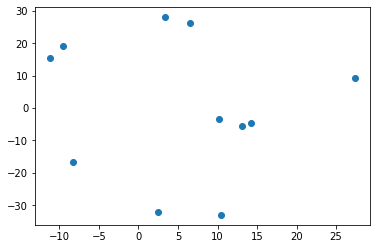

In [38]:
visualize_alldetections(df_complete, 1)

# Tracker Skeleton

In [39]:
### Define some useful constants

dt = clock_rate = 0.08
new_time_threshold = 7
active_time_threshold = 8
speed_acc_window = 5
H = np.array([[1.,0.,0., 0., 0., 0., 0., 0., 0.],[0.,0., 0.,1., 0., 0., 0., 0., 0.],[0.,0., 0., 0., 0., 0.,1., 0., 0.]])
max_dist_threshold = 10


def linear_transition_matrix(dt):
    return np.array([[1., dt, 0.5*dt**2, 0., 0., 0., 0., 0., 0.], [0, 1, dt, 0., 0., 0., 0., 0., 0. ], [0.,0.,1., 0., 0., 0., 0., 0., 0.],
               [0.,0.,0.,1.,dt,0.5*dt**2,0.,0.,0.],[0.,0.,0.,0.,1.,dt,0.,0.,0.],[0.,0.,0.,0.,0.,1.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.,1.,dt,0.5*dt**2],[0.,0.,0.,0.,0.,0.,0.,1.,dt], [0.,0.,0.,0.,0.,0.,0.,0.,1.]])



In [40]:
### Class representing a single detection

class Object:
    def __init__(self, x, y, z, l, w, h, angle, camera):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle
        self.camera = camera
        
    def to_df(self):
        
        df = pd.DataFrame([[self.x, self.y, self.z, self.length, self.width, self.height, self.angle, self.camera]], 
                         columns = ['X_box', 'Y_box', 'Z_box', 'length_box', 'width_box', 'height_box', 'angle_box', 'camera'])

        return df
    
    def __repr__(self):
        return "x: %f, y:%f, z:%f, length:%f, width:%f, height:%f, angle:%f, camera:%d \n" %(self.x, self.y, self.z, self.length, self.width, self.height, self.angle, self.camera)
    
    def __str__(self):
        return "x: %f, y:%f, z:%f \n" %(self.x, self.y, self.z)

In [95]:
### Class representing the Tracks

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = new_time_threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = [0.5, 0.5, 0.5]
        self.acceleration = [0.2, 0.2, 0.2]
        self.type = None
        self.threshold = new_time_threshold
        self.filter = None
        self.new_time = 1
        self.pending_time = 0
        self.active_time = 0
        self.all_positions = [[OBJ.x, OBJ.y, OBJ.z]]
        
        self.set_Kalman_Filter(x0 = OBJ)
    
    def update(self, OBJ, FRAME):
        
        if OBJ is not None:
            self.objects.append(OBJ)
            self.frames.append(FRAME)
            if self.status == 'New':
                #run iou tracker to get the estimate of speed, and update KF accordingly. 
                # In the meantime, get the next position from the object
                # assuming obj contains the right thing, here we adopt a different approach on it dep on the status
                self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
                last_xs = np.array([obj.x for obj in self.objects])
                last_ys = np.array([obj.y for obj in self.objects])
                last_zs = np.array([obj.z for obj in self.objects])
                if len(last_xs)>1:
                    self.velocity[0] = np.mean(last_xs[1:]-last_xs[:-1]/dt)
                    self.velocity[1] = np.mean(last_ys[1:]-last_ys[:-1]/dt)
                    self.velocity[2] = np.mean(last_zs[1:]-last_zs[:-1]/dt)
                if len(last_xs)>2:
                    self.acceleration[0] = (last_xs[2:] - 2* last_xs[1:-1] + last_xs[:-2])[0]/(dt**2)
                    self.acceleration[1] = (last_ys[2:] - 2* last_ys[1:-1] + last_ys[:-2])[0]/(dt**2)
                    self.acceleration[2] = (last_zs[2:] - 2* last_zs[1:-1] + last_zs[:-2])[0]/(dt**2)
                self.filter.x = np.array([self.x,self.velocity[0], self.acceleration[0],
                                          self.y,self.velocity[1], self.acceleration[1],
                                          self.z,self.velocity[2], self.acceleration[2]])
                
                self.new_time += 1
                if self.new_time > self.threshold:
                    self.status = 'Active'
            else:
                # how do I get the elapsed time between observations? assume we put it in dt
                self.filter.F = linear_transition_matrix(dt)
                # self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
                self.update_Kalman_Filter(dt, np.array([OBJ.x, OBJ.y, OBJ.z]))

                if self.active_time < active_time_threshold: # keep using iou while also training KF
                    self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
                    last_xs = np.array([obj.x for obj in self.objects[-speed_acc_window:]])
                    last_ys = np.array([obj.y for obj in self.objects[-speed_acc_window:]])
                    last_zs = np.array([obj.z for obj in self.objects[-speed_acc_window:]])
                    
                    self.velocity[0] = np.mean(last_xs[1:]-last_xs[:-1]/dt)
                    self.velocity[1] = np.mean(last_ys[1:]-last_ys[:-1]/dt)
                    self.velocity[2] = np.mean(last_zs[1:]-last_zs[:-1]/dt)
                    
                    self.acceleration[0] = (last_xs[2:] - 2* last_xs[1:-1] + last_xs[:-2])[0]/(dt**2)
                    self.acceleration[1] = (last_ys[2:] - 2* last_ys[1:-1] + last_ys[:-2])[0]/(dt**2)
                    self.acceleration[2] = (last_zs[2:] - 2* last_zs[1:-1] + last_zs[:-2])[0]/(dt**2)
                    
                    
                    
                else:
                    self.x = self.filter.x[0] # maybe these are not needed as we have the filter ones
                    self.y = self.filter.x[3]
                    self.z = self.filter.x[6]
                    self.velocity = [self.filter.x[1], self.filter.x[4], self.filter.x[7]]
                    self.acceleration = [self.filter.x[2], self.filter.x[5], self.filter.x[8]]
                    
                self.status = 'Active'
            self.all_positions.append([self.x,self.y,self.z])
            
            # adding: if track is new look for previous frames and get iou estimate of the speed 
        
        if OBJ is None and self.status == 'New':
            if self.new_time == 1: self.status = 'Removed'
            else: self.new_time += 1
        
        if OBJ is None and self.status == 'Active':
            self.status = 'Pending'
            self.pending_time += 1
        
        if OBJ is None and self.status == 'Pending':
            if self.pending_time == 5: self.status = 'Inactive'
            else: self.pending_time += 1
        
        return
    
    def set_status(self, status):
        self.status = status
        
        return
    
    def to_df(self):
        '''Print Trajectory as Dataframe'''
        df = pd.DataFrame(columns = ['X_box', 'Y_box', 'Z_box', 'length_box', 'width_box', 'height_box', 'angle_box', 'camera'])
        for i, j in enumerate(self.objects):
            append_df = j.to_df()
            append_df['frame'] = self.frames[i]       
            df = df.append(append_df)
            df.reset_index(inplace=True, drop=True)
            
        return df
    
    def set_Kalman_Filter(self, model_type='ca', x0=None, dt=dt):
        
        if x0 is None:
            x0 = np.array([0, 0.5, 0.2, 0, 0.5, 0.2, 0, 0.5, 0.2])
        if model_type == 'ca':
            self.filter = KalmanFilter (dim_x=9, dim_z=3)
            self.filter.x = np.array([x0.x, 0.5, 0.2, x0.y, 0.5, 0.2, x0.z, 0.5, 0.2])
            self.filter.F = linear_transition_matrix(dt)
            self.filter.H = H
            self.filter.P *= 0.1 
            self.filter.Q = np.eye(9) * 0.005 
            self.filter.R = np.diag(np.array([0.5, 0.2, 0.05])) * 0.01 
            
    def update_Kalman_Filter(self, dt, y):
        
        y = np.array(y)
        self.filter.predict()
        self.filter.update(y)
        
        return
    
    def __str__(self):
        return "ID: %d, status: %s, x: %f, y:%f, z:%f, new_time: %f, pending_time: %f, objects_count: %d, frame_count: %d"%(self.ID, self.status, self.x, self.y, self.z, self.new_time, self.pending_time, len(self.objects), len(self.frames))
    
    def __repr__(self):
        return "ID %d - TimeNew %d\n - Last coords (%f,%f,%f)" %(self.ID, self.new_time, self.x, self.y, self.z)
    
    def detection_vs_filter(self):
        plt.figure()
        plt.title('Detections vs Filter for Track: '+ str(self.ID))
        abscissa = [pos[0] for pos in self.all_positions ]
        ordinate = [pos[1] for pos in self.all_positions ]
        plt.ylim((np.min(ordinate)-5,np.max(ordinate)+5))
        plt.xlim((np.min(abscissa)-5,np.max(abscissa)+5))
        plt.scatter(abscissa[0], ordinate[0], color = 'r')
        plt.plot(abscissa, ordinate, color = 'r', label = 'Filter')
        plt.scatter(abscissa[-1], ordinate[-1], color = 'r')
        abscissa = [pos.x for pos in self.objects]
        ordinate = [pos.y for pos in self.objects]
        plt.scatter(abscissa[0], ordinate[0], color = 'b')
        plt.plot(abscissa, ordinate, color = 'b', label = 'Detection')
        plt.scatter(abscissa[-1], ordinate[-1], color = 'b')
        
        plt.legend()
        return 
    
    

In [59]:
### Methods to compute IoU and associate boxes through IoU

def belongs_to(point, box, isdf=False):
    """Utility function that returns true if the point is found within the box, false otherwise"""
    
    if isdf:
        center = box[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
        point = np.array([i for i in point]) - center
        anti_rotation_matrix = np.array([[np.cos(-box['angle_box'].to_numpy()[0]), -np.sin(-box['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(-box['angle_box'].to_numpy()[0]), np.cos(-box['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
        rot_point = anti_rotation_matrix.dot(point)
        
        if np.abs(rot_point[0])<box['length_box'].to_numpy()/2 and np.abs(rot_point[1])<box['width_box'].to_numpy()/2 and np.abs(rot_point[2])<box['height_box'].to_numpy()/2:
            return True
        return False
    
    center = np.array([i for i in box[0]])
    point = np.array([i for i in point]) - center
    anti_rotation_matrix = np.array([[np.cos(-box[4]), -np.sin(-box[4]), 0], 
                            [np.sin(-box[4]), np.cos(-box[4]), 0], 
                            [0,0,1]])
    rot_point = anti_rotation_matrix.dot(point)
    
    if np.abs(rot_point[0])<box[1]/2 and np.abs(rot_point[1])<box[2]/2 and np.abs(rot_point[2])<box[3]/2:
        return True
    return False

def compute_approx_IoU(box1, box2, attempts=100): 
    
    """Compute an approximated IoU between two boxes with a Monte Carlo approach"""
    

    pos1 = box1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    pos2 = box2[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    length1 = box1['length_box'].to_numpy()[0]
    width1 = box1['width_box'].to_numpy()[0]
    height1 = box1['height_box'].to_numpy()[0]
    length2 = box2['length_box'].to_numpy()[0]
    width2 = box2['width_box'].to_numpy()[0]
    height2 = box2['height_box'].to_numpy()[0]
    diag1 = np.sqrt(length1**2+width1**2+height1**2)
    diag2 = np.sqrt(length2**2+width2**2+height2**2)
    rotation_matrix1 = np.array([[np.cos(box1['angle_box'].to_numpy())[0], -np.sin(box1['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box1['angle_box'].to_numpy()[0]), np.cos(box1['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    rotation_matrix2 = np.array([[np.cos(box2['angle_box'].to_numpy()[0]), -np.sin(box2['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box2['angle_box'].to_numpy()[0]), np.cos(box2['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    
    
    if np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)>max(diag1, diag2):
        return 0
    intersection = 0
   
    for i in range(attempts):
        u = np.random.uniform(-1,1,size=3) * np.array([length1,width1,height1])/2 
        u = rotation_matrix1.dot(u)
        if belongs_to(u + np.array([i for i in pos1]), box2, True):
            intersection +=1
        u = np.random.uniform(-1,1,size=3) * np.array([length2,width2,height2])/2 
        u = rotation_matrix2.dot(u)
        if belongs_to(u + np.array([i for i in pos2]), box1, True):
            intersection +=1
    return intersection/2/attempts



In [43]:
### Functions used to associate tracks and detections

def find_subsequent_boxes(track_list1, track_list2):
    """
    Returns a numpy array of the best matches of boxes in track_list2 for boxes in track_list1, if any.
    If no IoU above a fixed threshold is found, -1 is assigned.
    """
    
    iou_vals = np.zeros(shape=(len(track_list1), len(track_list2)))
    
    for i in range(len(track_list1)):
        for j in range(len(track_list2)):

            df1 = track_list1[i].to_df()
            last_frame = df1.frame.max()
            iou = compute_approx_IoU(df1[df1.frame==last_frame],track_list2[j].to_df())
            iou_vals[i][j] = iou
        
    return iou_vals

def track_detection_association(track_coord, obj_coord):
    ''' Function for computing the euclidean distance between detections and predicted track positions'''
    
    dists = cdist(track_coord, obj_coord, 'euclidean') 

    return dists

### Perform association of objects in previous and next frame

def associate(tracks, obj_list, frame_index):
    
    all_tracks = tracks.items()
    all_tracks = np.array([track for cat, trs in all_tracks if cat in ['Active', 'New', 'Pending'] for track in trs])
    track_coord = np.array([[t.x, t.y, t.z] for t in all_tracks]) 
    track_indices = np.array([t.ID for t in all_tracks])
    
    if track_coord.size and len(obj_list) > 0:
        
        # explore with iou
        
        iou_values = find_subsequent_boxes(all_tracks, obj_list)

        obj_coord = [(obj.x, obj.y, obj.z) for obj in obj_list]
        dist_values = track_detection_association(track_coord, obj_coord)
        
        complete_dists = 0.9 * (1-iou_values) + 0.1 * dist_values
        
        object_associations = complete_dists.argmin(axis=0)
        best_dists_obj = complete_dists.min(axis=0)
        
        best_dist = complete_dists.min()
        object_associations[best_dists_obj>best_dist+max_dist_threshold] = -1
        
        associations = - np.ones(shape=len(all_tracks), dtype=np.int8)
        final_distances = - np.ones(shape=len(all_tracks))
        
        for index in range(len(associations)):
            correspondences = np.where(object_associations==index)[0]
            best_sub_dists = best_dists_obj[correspondences]

            if(len(correspondences)>0):
                idx = np.argmin(best_sub_dists)
                associations[index] = correspondences[idx]
                final_distances[index] = best_sub_dists[idx]
            
        
        #print("Track IDs and corresponding distances: ")
        #print(track_indices)
        #print(final_distances)
        
        for index, ass in enumerate(associations):
            if ass == -1:
                all_tracks[index].update(None, frame_index)
            else:
                all_tracks[index].update(obj_list[ass], frame_index)

        obj_list = np.delete(obj_list, associations)
    

    return obj_list

In [47]:
# Function needed to join cameras

from copy import copy
from scipy import stats
pd.options.mode.chained_assignment = None

def custom_prob(obj1, obj2):
    
    #Mean is center of obj1, std dimension of the boxes, we mulltiply cov by a coefficient related to distance in time
    time_coef = 0.05 #0.05 Ok with 0.06 as timestep, probably better 0.03 with 0.08
    mean = obj1[0:3]
    std = obj1[3:6]
    cov = np.diag(np.power(std,2)) * np.exp(np.abs(obj1[7] - obj2[7])/time_coef, dtype = np.float64)

    x = obj2[:3]

    m_dist_x = np.dot((x-mean).transpose(),np.linalg.inv(cov))
    m_dist_x = np.dot(m_dist_x, (x-mean))
    
    dist = 1-stats.chi2.cdf(m_dist_x, 3)
    
    #If objs belong to same camera -> 0 prob of being same one
    if dist != 1 and obj1[9] == obj2[9] and obj1[7] == obj2[7]:
        return 0
    
    return dist

def unify(frame):
    
    #Convert Frame to array
    frame_values = frame.iloc[:,:].values
    
    
    #Compute probabilities
    dists = cdist(frame_values, frame_values, custom_prob)
    
    #Create index array
    index = np.empty(shape = (len(frame.index)))
    index[:] = np.nan
    
    #Compute first argmax
    argmax = np.unravel_index(dists.argmax(), dists.shape)
    max_value = np.max(dists) 
    
    #Cycle on maxima
    while max_value > 0.35:
    
        if argmax[0] == argmax[1]:
            dists[argmax] = -1

        if argmax[0] != argmax[1]:
            if dists[argmax[0], argmax[1]] > 0.5 and dists[argmax[1], argmax[0]] > 0.1:
                if np.isnan(index[argmax[1]]):
                    if np.isnan(index[argmax[0]]):
                        index[argmax[0]] = argmax[0]
                    index[argmax[1]] = index[argmax[0]]
            dists[argmax] = -1
    
        argmax = np.unravel_index(dists.argmax(), dists.shape)
        max_value = dists[argmax]

    #Fill index vectors
    for i in range(index.shape[0]):
        if np.isnan(index[i]):
            index[i] = i
    
    #Add index column
    frame['object_index'] = index
    
    return

In [48]:
# Class tracker

class Tracker:
    
    def __init__(self, dfs):
        self.tracks = {'Active': [], 'Pending': [], 'Inactive': [], 'New': [], 'Removed': []}
        self.dataframe = concatenate_dfs(dfs, ['frame', 'camera'])
        self.track_id = 0 
        self.time = -0.06
        self.current_objects = pd.DataFrame()
        self.frame_index = -1
        
    
    def update_tracks(self):
        ''' Update the status of the tracks, moving them to the different lists'''
        for tr in self.tracks['New'][::-1]:
            if tr.status != 'New':
                self.tracks['New'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Pending'][::-1]:
            if tr.status != 'Pending':
                self.tracks['Pending'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Active'][::-1]:
            if tr.status != 'Active':
                self.tracks['Active'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        return
    
    def next_step(self):
        '''Proceed with next time step analysis of frames'''
        #''' Increase time step of the camera'''
        self.frame_index += 1
        self.time += clock_rate
        self.current_objects = self.dataframe[np.abs(self.dataframe['elapsed_time']-self.time)<=clock_rate/2]# very unlikely one happens to be EXACTLY in the middle
        self.merge_collisions()
        self.analyze_frame()
        
    
    def analyze_frame(self):
        ''' Analyze frame creating or updating trajectories'''
        
        frame = self.current_objects 
        obj_list = []
        
        # Extract all the detections in the frame
        for index, row in frame.iterrows():
            obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], 
                         row['width_box'], row['height_box'], row['angle_box'], row['camera'])
            obj_list.append(obj)

        obj_list = np.array(obj_list)
        
        # Perform associations
        obj_list = associate( self.tracks, obj_list, self.frame_index)
        
        # Check status of all tracks
        self.update_tracks()        
        
        #Create new tracks for not linked objects
        for obj in obj_list:
            tr = Track(self.track_id, obj, self.frame_index)
            self.track_id += 1
            self.tracks['New'].append(tr)
        
        
    def merge_collisions(self):
        
        if 'credibility_level' not in self.current_objects:
            credibility_level(self.current_objects)
        
        unify(self.current_objects)
        labeled_df = self.current_objects
        
        if np.all(labeled_df.groupby(['object_index']).count()==1):
            return 
        
        labeled_df.loc[:,~labeled_df.columns.isin(['credibility_level', 'camera', 'object_index'])] = labeled_df.loc[:,~labeled_df.columns.isin(['credibility_level', 'camera', 'object_index'])].multiply(labeled_df.credibility_level, axis='index')
        
        
        labeled_df = labeled_df.groupby(['object_index']).sum()
        labeled_df = labeled_df.divide(labeled_df.credibility_level, axis='index')
        labeled_df = labeled_df.drop(['credibility_level', 'frame'], axis=1)
        
        self.current_objects = labeled_df
        self.current_objects['elapsed_time'] = self.time
        
        return
    
    def iterate_for(self,n_iter):
        for i in range(n_iter):
            self.next_step()
            self.summary_track_types(i)
        
        cmap = plt.get_cmap('tab20')
        num = len(cmap.colors)
        colors = [cmap(i) for i in np.linspace(0,1,num)]
        self.print_tracks(colors, num)

        return
    
    def print_tracks(self,colors,num_cols):
        plt.figure()
        plt.title("plot of Active and New Tracks")
        for t in self.tracks['Active']:
            abscissa = [pos[0] for pos in t.all_positions ]
            ordinate = [pos[1] for pos in t.all_positions ]
            plt.scatter(abscissa[0], ordinate[0], color = colors[t.ID%num_cols])
            # plt.annotate(t.ID, (abscissa[0],ordinate[0]))
            plt.plot(abscissa, ordinate, color = colors[t.ID%num_cols])
            plt.scatter(abscissa[-1], ordinate[-1], color = colors[t.ID%num_cols])
            
        for t in self.tracks['New']:
            abscissa = [pos[0] for pos in t.all_positions ]
            ordinate = [pos[1] for pos in t.all_positions ]
            plt.scatter(abscissa[0], ordinate[0], color = colors[t.ID%num_cols])
            # plt.annotate(t.ID, (abscissa[0],ordinate[0]))
            plt.plot(abscissa, ordinate, color = colors[t.ID%num_cols])
            plt.scatter(abscissa[-1], ordinate[-1], color = colors[t.ID%num_cols])
        return
        
    
    def summary_track_types(self, n ):
        print("-------------------------------- Iteration N° ", n+1, "--------------------------------")
        print("Active tracks: ", len(self.tracks['Active']), 5*" ", "New tracks: ", len(self.tracks['New']),
              5*" ", "Pending tracks: ", len(self.tracks['Pending']), 5*" ", "Removed tracks: ", 
              len(self.tracks['Removed']) ,5*" ", "Inactive tracks: ", len(self.tracks['Inactive']) )
        print("\n")
    
        return

-------------------------------- Iteration N°  1 --------------------------------
Active tracks:  0       New tracks:  8       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  2 --------------------------------
Active tracks:  0       New tracks:  10       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  3 --------------------------------
Active tracks:  0       New tracks:  10       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  4 --------------------------------
Active tracks:  0       New tracks:  12       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  5 --------------------------------
Active tracks:  0       New tracks:  14       Pending tracks:  0       Removed tracks:  1       Inactive tracks:  0


-

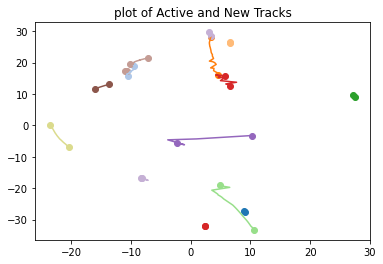

In [96]:
# Create Tracker, analyze some frames
TrackTrack = Tracker([df_109,df_130,df_142,df_143])
TrackTrack.iterate_for(30)

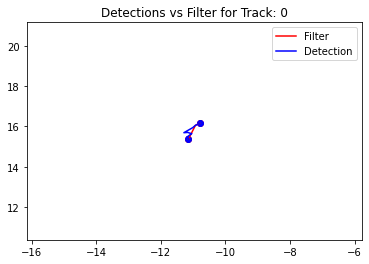

In [63]:
TrackTrack.tracks['Active'][6].detection_vs_filter()

In [104]:
TrackTrack.tracks['New'][2].detection_vs_filter()

IndexError: list index out of range

In [92]:
TrackTrack.tracks['Active'][7].all_positions

[[5.724435097084088, 15.772091964857701, -1.0989524986743555],
 [6.432459199348687, 12.809710277426486, -0.9081561190371331],
 [6.548368088290856, 12.428639034820197, -0.9568454536423527]]

In [85]:
TrackTrack.tracks['Active'][7].objects


[x: 5.724435, y:15.772092, z:-1.098952, length:1.952673, width:1.158571, height:0.769741, angle:-0.379129, camera:260 ,
 x: 4.191531, y:16.033495, z:-0.682201, length:1.863207, width:0.986122, height:0.755261, angle:0.232554, camera:207 ,
 x: 4.929567, y:15.731582, z:-0.903250, length:4.499789, width:1.233184, height:1.039213, angle:-0.074711, camera:217 ,
 x: 4.613442, y:15.249991, z:-0.921386, length:3.288256, width:1.657296, height:1.065062, angle:0.077234, camera:217 ,
 x: 5.641177, y:15.159362, z:-0.976329, length:4.104951, width:1.970949, height:1.195797, angle:0.111761, camera:217 ,
 x: 4.983962, y:14.228612, z:-1.030154, length:4.394815, width:1.725710, height:1.065845, angle:0.286859, camera:217 ,
 x: 7.680460, y:13.716622, z:-1.222706, length:7.999711, width:3.331686, height:2.184798, angle:-0.203390, camera:260 ,
 x: 5.872354, y:13.174761, z:-0.880203, length:5.220095, width:2.335496, height:1.431420, angle:-0.026100, camera:217 ,
 x: 6.432459, y:12.809710, z:-0.908156, leng

In [94]:
df_complete[df_complete['frame'] == 21]

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time,credibility_level
255,-10.345101,16.614414,-1.310348,1.682396,1.111229,1.633540,-0.226735,1.574333e+09,21,109,1.683341,1.00
256,4.031595,20.347791,-1.056684,6.344770,2.523965,1.850589,-1.181636,1.574333e+09,21,109,1.683341,1.00
257,-8.099512,20.998620,-1.169665,0.735845,0.557080,1.408767,0.588384,1.574333e+09,21,109,1.683341,1.00
258,6.521189,26.567256,-0.825263,2.232152,0.562733,1.207123,0.951284,1.574333e+09,21,109,1.683341,1.00
259,5.604898,15.602146,-1.095399,1.936882,1.537682,0.831729,-0.105670,1.574333e+09,21,130,1.727656,0.50
260,3.373391,-21.211568,-1.098493,4.227082,3.228448,2.670570,-0.065334,1.574333e+09,21,142,1.687656,0.75
261,7.862506,-16.853498,-0.881723,1.216469,0.627697,0.692648,-0.535294,1.574333e+09,21,142,1.687656,0.75
262,-21.972788,-4.250887,-0.983132,1.760713,0.756044,2.014264,-1.172772,1.574333e+09,21,142,1.687656,1.00
263,4.390042,15.785769,-0.453855,1.708591,0.925691,0.350791,0.455752,1.574333e+09,21,142,1.687656,0.75
264,0.174555,17.251275,-1.281587,4.958470,0.656812,2.072166,0.697676,1.574333e+09,21,142,1.687656,0.75
